# Text Classification
Thus far we have focused our attention on regression and classification problems involving data characterized by numbers: pixel intensities in images, features described by numerical values.  There have certainly been some cases where some of the feature data was text - for example the housing price data we started with in the first week of class.   What we did with that data was immediately convert that data to a numerical represention.   That was relatively easy, since the text data fell into a small number of discrete categories, which we could easily label with numbers.

However, there are a large class of problems where the **only** information we have is textual.   What do we do in this case?

We will start our investigation using a well-known dataset: the "20 newsgroups dataset".  The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.

I have already read in this data, and put the results into a pickle file:

In [1]:
import pickle
#
# Load our data
fnames,labelnames,texts = pickle.load(open('/fs/scratch/PAS1495/physics6820/text/20_newsgroup/preprocessed/20newsgroups_fnames_labelnames_texts.pkl', 'rb') )
#
# What are the unique labels?  Convert the label list ot a set!
uniqueLabels = set(labelnames)

print("20 Newsgroups Labels:")
for label in uniqueLabels:
    print("   ", label)

20 Newsgroups Labels:
    talk.politics.guns
    comp.sys.mac.hardware
    sci.space
    rec.sport.hockey
    alt.atheism
    sci.med
    talk.politics.mideast
    comp.sys.ibm.pc.hardware
    talk.religion.misc
    comp.graphics
    talk.politics.misc
    sci.electronics
    rec.motorcycles
    rec.autos
    soc.religion.christian
    comp.os.ms-windows.misc
    sci.crypt
    rec.sport.baseball
    misc.forsale
    comp.windows.x


# Shuffle
Shuffle the text and labels coherently.

In [2]:
import numpy as np
from random import shuffle
from keras.utils import to_categorical#
from sklearn.preprocessing import LabelBinarizer

# Do an ordered shuffle of correlated arrays
def shuffle_list(*ls):
  l =list(zip(*ls))
  shuffle(l)
  return zip(*l)

# Shuffle the labels and text coherently
slabels,stexts = shuffle_list(labelnames,texts)

#
# Convert our labels names to one-hot encoded versions
lb = LabelBinarizer()
slabels_onehot = lb.fit_transform(slabels)
indexToLabel = {}
labelToIndex = {}
for i in range(len(slabels)):
    if i<10:
        print(" Label",slabels[i],"; encoding",slabels_onehot[i])
    decVal = lb.inverse_transform(slabels_onehot[[i]])[0]
    index = np.argmax(slabels_onehot[i])
    indexToLabel[index] = decVal
    labelToIndex[decVal] = index
print()
print("This gives us a lookup table which goes from index (position in 1-hot encoding) to label:")
print("indexToLabel: ",indexToLabel)
print()
print("This gives us a lookup table which goes from label back to index:")
print("labelToIndex: ",labelToIndex)
#
# Make a train/test split
VALIDATION_SPLIT = 0.2
num_validation_samples = int(VALIDATION_SPLIT * len(texts))

train_posts = stexts[:-num_validation_samples]
y_train = slabels_onehot[:-num_validation_samples]
test_posts = stexts[-num_validation_samples:]
y_test = slabels_onehot[-num_validation_samples:]
y_test_labels = slabels[-num_validation_samples:]


Using TensorFlow backend.


 Label comp.os.ms-windows.misc ; encoding [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 Label talk.politics.mideast ; encoding [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 Label soc.religion.christian ; encoding [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 Label comp.sys.ibm.pc.hardware ; encoding [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 Label comp.graphics ; encoding [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 Label comp.windows.x ; encoding [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 Label soc.religion.christian ; encoding [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 Label misc.forsale ; encoding [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 Label sci.crypt ; encoding [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 Label rec.motorcycles ; encoding [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]

This gives us a lookup table which goes from index (position in 1-hot encoding) to label:
indexToLabel:  {2: 'comp.os.ms-windows.misc', 17: 'talk.politics.mideast', 15: 'soc.religion.christian', 3: 'comp.sys.ibm.pc

# Keras Tokenize
Fo processing text, Keras provides a Tokenizer function.   The idea is to turn the words in our text into:
* numbers: each word is converted to a specific number
* sequences: each document - which is a list of words in a specific order - is converted to a sequence of numbers in a corresponding specific order.
* vectors: each document can be veiwed as a **sparse** vector, with a 1 in the numeric ordered spot if the text contains that word, a zero otherwise

The Keras Tokenize class also lowercases and remove punctuations.   

Let's see how this works with a list of very short documents.

In [3]:
from keras.preprocessing.text import Tokenizer

docs = ["This is a sentence about condensed matter physics.",
           "I just read some papers about high energy physics.",
           "Theoretical physics is more than just pushing pencils and paper around.",
           "The Nodel Prize in Physics this year (2018) went to Askin, Mourou, and Strickland for their groundbreaking inventions in the field of laser physics"]

vocab_size = 5
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(docs)
#
# Get summary info from the tokenizer
print("Word indices and document links: ")
for word in tokenizer.word_index:
    print("  word:",word,"; Index:",tokenizer.word_index[word],"; documents:",tokenizer.word_docs[word])

# integer encode documents
#  mode: one of "binary", "count", "tfidf", "freq".
encoded_docs_matrix = tokenizer.texts_to_matrix(docs, mode='binary')
encoded_docs_sequence = tokenizer.texts_to_sequences(docs)
for docnum in range(len(docs)):
    print()
    print("Orginal Text: ",docs[docnum])
    print("As a vector:  ",encoded_docs_matrix[docnum])
    print("As a sequence ", encoded_docs_sequence[docnum])


Word indices and document links: 
  word: physics ; Index: 1 ; documents: 4
  word: this ; Index: 2 ; documents: 2
  word: is ; Index: 3 ; documents: 2
  word: about ; Index: 4 ; documents: 2
  word: just ; Index: 5 ; documents: 2
  word: and ; Index: 6 ; documents: 2
  word: the ; Index: 7 ; documents: 1
  word: in ; Index: 8 ; documents: 1
  word: a ; Index: 9 ; documents: 1
  word: sentence ; Index: 10 ; documents: 1
  word: condensed ; Index: 11 ; documents: 1
  word: matter ; Index: 12 ; documents: 1
  word: i ; Index: 13 ; documents: 1
  word: read ; Index: 14 ; documents: 1
  word: some ; Index: 15 ; documents: 1
  word: papers ; Index: 16 ; documents: 1
  word: high ; Index: 17 ; documents: 1
  word: energy ; Index: 18 ; documents: 1
  word: theoretical ; Index: 19 ; documents: 1
  word: more ; Index: 20 ; documents: 1
  word: than ; Index: 21 ; documents: 1
  word: pushing ; Index: 22 ; documents: 1
  word: pencils ; Index: 23 ; documents: 1
  word: paper ; Index: 24 ; documen

In [4]:
from keras.preprocessing.text import Tokenizer

# 20 news groups
num_labels = len(uniqueLabels)
vocab_size = 10000
batch_size = 100
 
# define Tokenizer with Vocab Size

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_posts)

x_train = tokenizer.texts_to_matrix(train_posts, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test_posts, mode='tfidf')

print("True vocabulary size:",len(tokenizer.word_index))


True vocabulary size: 150693


# Fitting a Keras Model
This is just a simple fully connected network.

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten, Dropout
from keras.models import Model
from keras.initializers import Constant


##### import keras
model = Sequential()
model.add(Dense(100, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(50, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model_20newsgroups.mlp.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
]

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=callbacks_list,
                    validation_data=(x_test, y_test))
patience = 4
best_val_acc =  history.history['val_acc'][-(patience+1)]
print("Best validation accuracy is:",best_val_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1000100   
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
activation_2 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1020      
__________

# Analysis
We look at a few things:
1.  The standard confusion matrix.
2.  The number of classes which were predicted incorrectly (where the highest predicted probability class was wrong) *AND* the subset of these in which the 2nd highest predicted probability class was correct.   If this was random we would expect that about 10% (since there are 10 remaining classes) of the number incorrectly predicted would have the second highest probability be correct.   Instead this number is more like 60%.
3.  A modified confusion matrix where we count the correct classifications to be those in which one of the two highest predicted classes was correct.

TRUE:  sci.space ;	 PREDICTED:  sci.space
TRUE:  sci.electronics ;	 PREDICTED:  sci.electronics
TRUE:  misc.forsale ;	 PREDICTED:  sci.electronics
TRUE:  comp.sys.ibm.pc.hardware ;	 PREDICTED:  comp.sys.ibm.pc.hardware
TRUE:  comp.sys.mac.hardware ;	 PREDICTED:  comp.sys.mac.hardware
TRUE:  sci.med ;	 PREDICTED:  sci.med
TRUE:  comp.windows.x ;	 PREDICTED:  comp.windows.x
TRUE:  comp.sys.ibm.pc.hardware ;	 PREDICTED:  comp.sys.ibm.pc.hardware
TRUE:  comp.sys.ibm.pc.hardware ;	 PREDICTED:  comp.os.ms-windows.misc
TRUE:  sci.space ;	 PREDICTED:  sci.space

Standard confusion matrix and accuracy when using the highest predicted prob to get predicted class.
talk.politics.guns 	0.92 	0.0 	0.0 	0.0 	0.0 	0.0 	0.01 	0.0 	0.01 	0.0 	0.04 	0.0 	0.01 	0.01 	0.0 	0.0 	0.01 	0.0 	0.0 	0.0 	
comp.sys.mac.hardware 	0.01 	0.8 	0.0 	0.01 	0.0 	0.0 	0.0 	0.07 	0.0 	0.02 	0.01 	0.03 	0.01 	0.01 	0.0 	0.01 	0.0 	0.0 	0.03 	0.01 	
sci.space 	0.0 	0.0 	0.95 	0.0 	0.0 	0.0 	0.0 	0.0 	0.01 	0.01 	0.0 	0.0 	0

/apps/python/3.6-conda5.2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


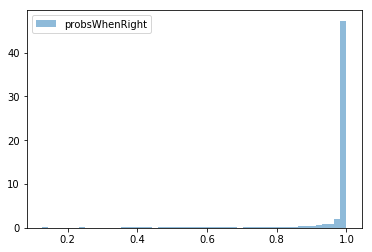

In [6]:
from collections import defaultdict
from functools import partial
from matplotlib import pyplot as plt
%matplotlib inline

#
# Get our predictions for each sample in the test sample
y_test_pred = model.predict(x_test)

#
# Containers to store some resuls
trueCount = defaultdict(int)
confusionMatrix = defaultdict(partial(defaultdict, int))
probsWhenRight = []

#
# Loop over data and collect results
for i in range(len(y_test_labels)):
    t_test_index = labelToIndex[y_test_labels[i]]
    trueCount[y_test_labels[i]] += 1
    predLabelIndex = np.argmax(y_test_pred[i])
    predLabel = indexToLabel[predLabelIndex]
    predictedProbability = y_test_pred[i][predLabelIndex]
    if i<10:
        print("TRUE: ",y_test_labels[i],";\t PREDICTED: ",predLabel)
    confusionMatrix[y_test_labels[i]][predLabel] += 1
#
# Store the probability when correct
    if y_test_labels[i] == predLabel:
        probsWhenRight.append(predictedProbability)
    
print()
print("Standard confusion matrix and accuracy when using the highest predicted prob to get predicted class.")
averageAcc = 0.0
num = 0.0
for i in uniqueLabels:
    print(i,'\t',end='')
    for j in uniqueLabels:
        print(round(float(confusionMatrix[i][j])/float(trueCount[i]),2),'\t',end='')
        if i==j:
            averageAcc += float(confusionMatrix[i][j])/float(trueCount[i])
            num += 1.0
    print()
print()
print("Average accuracy:",round(averageAcc/num,4))

plt.hist(probsWhenRight, 50, alpha=0.5, normed=True, label='probsWhenRight')
plt.legend(loc='upper left')
plt.show()


# EXTRA Credit (1 point each)
You can do these things to get extra credit!
1.  Add to the same plot above: The probabilities when the predicted class is wrong
2.  Count the number that are incorrectly predicted, and for this group, count up how often the correct class is the 2nd highest probability.   This [post](https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array) may be helpful (it is what I used)!  Is the second highest correct at a random rate?  Or is it much higher?
3.  Make a modified confusion matrix where we count the correct classifications to be those in which one of the two highest predicted classes was correct.